In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import sinter
import matplotlib.pyplot as plt
import os

from qecdec import RotatedSurfaceCode_Memory
from qecdec import DMemBPDecoder, SinterDecoderWrapper

In [4]:
d = 5
rounds = 5
p = 0.01
scaling_factor_list = np.arange(0, 1.0001, 0.05).tolist()
max_iter = 50
gamma = np.load("gamma.npy")

In [5]:
def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    # Setup the experiment.
    expmt = RotatedSurfaceCode_Memory(
        d=d,
        rounds=rounds,
        basis='Z',
        data_qubit_error_rate=p,
        meas_error_rate=p,
    )
    for scaling_factor in scaling_factor_list:
        # Setup a sinter.Task with BP decoder.
        dmembp = DMemBPDecoder(expmt.chkmat, expmt.prior,
                               gamma=gamma, max_iter=max_iter, scaling_factor=scaling_factor)
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(dmembp, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'scaling_factor': scaling_factor},
        ))
    return tasks, custom_decoders

tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()


In [6]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
21 tasks left:
  workers           decoder  eta shots_left errors_left json_metadata                     
        1  custom_decoder_0    ?   10000000         100 scaling_factor=0.0                
        1  custom_decoder_1    ?   10000000         100 scaling_factor=0.05               
        1  custom_decoder_2    ?   10000000         100 scaling_factor=0.1                
        1  custom_decoder_3    ?   10000000         100 scaling_factor=0.15000000000000002
        1  custom_decoder_4    ?   10000000         100 scaling_factor=0.2                
        1  custom_decoder_5    ?   10000000         100 scaling_factor=0.25               
        1  custom_decoder_6 793m    9999999         100 scaling_factor=0.30000000000000004
        0  custom_decoder_7  ?·∞   10000000         100 scaling_factor=0.35000000000000003
        0  custom_decoder_8  ?·∞   10000000         100 scaling_factor=0.4                
        0  custom_decoder_9  ?·∞   10000000         1

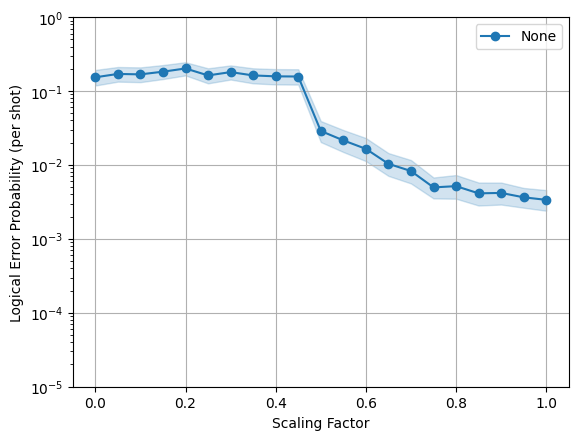

In [7]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    x_func=lambda stat: stat.json_metadata['scaling_factor'],
)
ax.semilogy()
ax.set_ylim(1e-5, 1)
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Scaling Factor')
ax.legend()